In [1]:
########################################################################
# Author    : A. Alsema
# Date      : Augustus 2021
# Dataset   : pseudobulked lesion cores, lesion rims and PLWM from Visium Spatial Transcriptomics for MS lesions
# Purpose   : create a volcano plot of differential genes between PLWM and NAWM

# Required inputs:
# - indir: directory with unthresholded differential expression results generated by script 0_differentialexpression
# - allgenes_<yourcomparison>.csv: csv with unthresholded differential expression table to plot
# - outdir: directory for plots printed as pdf
# Output    : pdf file with volcano plot

########################################################################

In [5]:
rm(list = ls())
library(ggrepel)
indir = "<your_indir>"
outdir = "volcanos/"

In [6]:
#' Add Information to differential expression table for gene plotting
#'
#' This function processes results from script 0 to create a data frame suitable for plotting, 
#' with significance categories and labels for genes based on FDR and fold change thresholds.
#'
#' @param inputDEG A data frame or csv table with differential expression results for all genes.
#' @param labelFDRthresh Numeric, the FDR threshold below which genes get a label.
#' @param labelFCthresh Numeric, the fold change threshold above which genes get a label.
#'
#' @return A data frame with added columns for significance, alpha transparency, and gene labels.
#' @export
addInfoDF <- function(inputDEG, labelFDRthresh, labelFCthresh) {
  
  inputDEGDF <- as.data.frame(inputDEG)
  
  # Initialize the 'Significant' column to "0"
  inputDEGDF$Significant <- "0"
  
  # Assign significance categories based on adjusted P-value and log fold change
  inputDEGDF$Significant[inputDEGDF$adj.P.Val < 0.05 & inputDEGDF$logFC > 1] <- "1"
  inputDEGDF$Significant[inputDEGDF$adj.P.Val < 0.05 & inputDEGDF$logFC < -1] <- "2"
  inputDEGDF$Significant[inputDEGDF$adj.P.Val < 0.05 & inputDEGDF$logFC > 2] <- "3"
  inputDEGDF$Significant[inputDEGDF$adj.P.Val < 0.05 & inputDEGDF$logFC < -2] <- "4"
  
  # Set alpha transparency values for the plot; non-significant genes have alpha 0.4
  inputDEGDF$alphaVal <- ifelse(inputDEGDF$Significant == "0", 0.4, 1)
  
  # Initialize the 'name' column to 0
  inputDEGDF$name <- 0
  
  # Label genes that meet the specified FDR and fold change thresholds
  inputDEGDF$name[inputDEGDF$adj.P.Val < labelFDRthresh & abs(inputDEGDF$logFC) > labelFCthresh] <- 1
  
  return(inputDEGDF)
}


In [13]:
####################### prepare plot for PL-active ###################### 

# load genes
results <- read.csv(paste0(indir,'allgenes_GroupPL_Active_vs_GroupNAWM.csv'), row.names = 1)
head(results)

# add significance color
df.volcano <- addInfoDF(results, labelFDRthresh = 0.05, labelFCthresh = 2.8)   # can play with the label thresholds
head(df.volcano)

# add some custom labels. 
# 1 means label, 0 means do not label
df.volcano$name[which(rownames(df.volcano) == "PARVA")] <- 1
df.volcano$name[which(rownames(df.volcano) == "ANXA1")] <- 1
df.volcano$name[which(rownames(df.volcano) == "CCND2")] <- 1
df.volcano$name[which(rownames(df.volcano) == "DAB2")] <- 1
df.volcano$name[which(rownames(df.volcano) == "RFTN1")] <- 1

# check if the rownames of df.volcano are gene symbols
df.volcano$geneSym <- rownames(df.volcano)

,logFC,AveExpr,t,P.Value,adj.P.Val,z.std
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EWSR1,-0.5166864,6.595965,-6.383403,1.106242e-06,0.01061718,-4.871732
CD44,2.6099743,8.047498,7.775001,1.591280e-06,0.01061718,4.799417
ST7,1.0385190,3.795466,6.088005,2.312370e-06,0.01061718,4.724012
ABCA1,2.8046965,5.940186,6.126401,2.580588e-06,0.01061718,4.701657
VIM,3.5614646,10.231873,6.784660,5.157608e-06,0.01598120,4.558273
UGCG,1.4863538,5.155448,5.942179,6.970722e-06,0.01598120,4.494581


,logFC,AveExpr,t,P.Value,adj.P.Val,z.std,Significant,alphaVal,name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
EWSR1,-0.5166864,6.595965,-6.383403,1.106242e-06,0.01061718,-4.871732,0,0.4,0
CD44,2.6099743,8.047498,7.775001,1.591280e-06,0.01061718,4.799417,3,1.0,0
ST7,1.0385190,3.795466,6.088005,2.312370e-06,0.01061718,4.724012,1,1.0,0
ABCA1,2.8046965,5.940186,6.126401,2.580588e-06,0.01061718,4.701657,3,1.0,1
VIM,3.5614646,10.231873,6.784660,5.157608e-06,0.01598120,4.558273,3,1.0,1
UGCG,1.4863538,5.155448,5.942179,6.970722e-06,0.01598120,4.494581,1,1.0,0


png 
  2

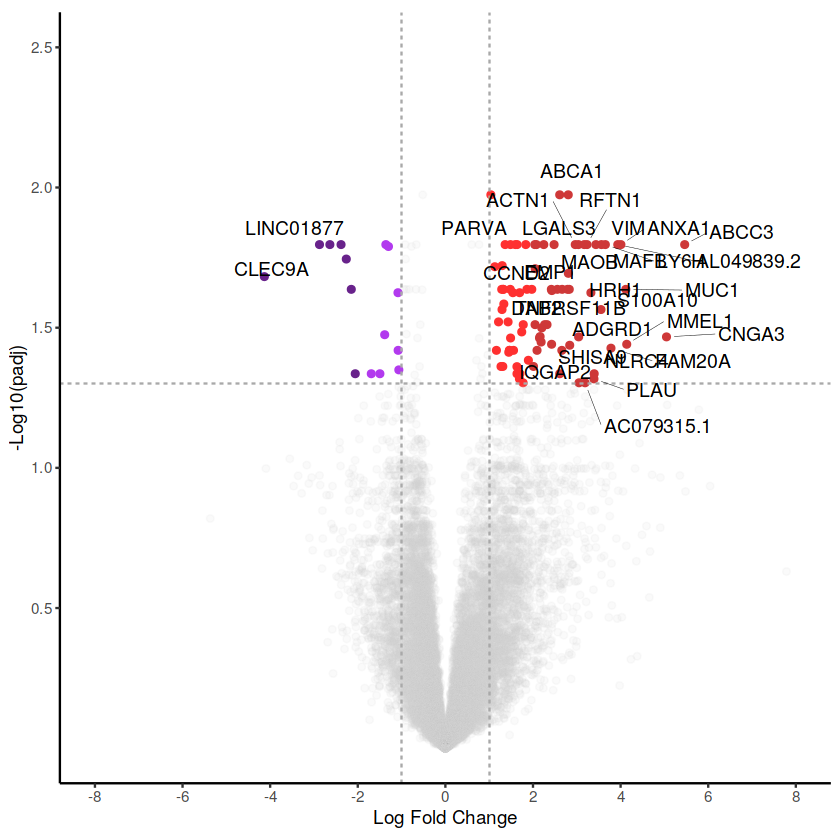

In [14]:
####################### ggplot #########################

p <- ggplot(df.volcano, aes(x=logFC, y=-log10(adj.P.Val))) +
  geom_point(aes(col=Significant, alpha = alphaVal)) +
  geom_hline(yintercept=-log10(0.05), linetype="dashed", color = "darkgrey") +
  geom_vline(xintercept = 1, linetype="dashed", color = "darkgrey") +
  geom_vline(xintercept = -1, linetype="dashed", color = "darkgrey") +
  geom_text_repel(aes(label=ifelse(name == 1 ,as.character(geneSym),'')),color="black", 
                  box.padding = unit(0.3, "lines"),
                  point.padding = unit(0.5, "lines"),
                  max.overlaps = 500,
                  segment.color = 'black', size = 4, segment.size = 0.1) +
  scale_x_continuous(limits = c(-8, 8), breaks = seq(-8,8,2)) +
  scale_y_continuous(limits = c(0, 2.5), breaks = seq(0.5,3,0.5)) +
  labs(x = "Log Fold Change", y = "-Log10(padj)", color="") +
  scale_color_manual(values = c("lightgrey", "firebrick1", "darkorchid2", "#ce3838", "darkorchid4")) + # active lesion colors
  theme(aspect.ratio = 1,
        plot.title = element_text(hjust = 0.5), 
        axis.line = element_line(colour = "black"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        panel.background = element_blank(), 
        legend.position="none")

pdf(paste0(outdir,"Volcano PL-active vs NAWM.pdf"), width = 5, height = 5) 
p
dev.off()
p


In [15]:
####################### prepare plot for PL-mixed inactive/active ###################### 
# load genes
results <- read.csv(paste0(indir,'allgenes_GroupPL_act.inact_vs_GroupNAWM.csv'), row.names = 1)
head(results)
# add significance color
df.volcano <- addInfoDF(results, labelFDRthresh = 0.05, labelFCthresh = 1.5)   # can play with the label thresholds
head(df.volcano)

# add some custom labels. 1 means label, 0 means do not label
df.volcano$name[which(rownames(df.volcano) == "PARVA")] <- 1
df.volcano$name[which(rownames(df.volcano) == "ANXA1")] <- 1
df.volcano$name[which(rownames(df.volcano) == "RFTN1")] <- 1
df.volcano$name[which(rownames(df.volcano) == "TLE1")] <- 1

# check rownames of df.volcano are gene symbols
df.volcano$geneSym <- rownames(df.volcano)


,logFC,AveExpr,t,P.Value,adj.P.Val,z.std
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EWSR1,-0.6449499,6.5959655,-7.854413,3.278845e-08,0.0005395995,-5.525855
ANO4,-2.0131004,3.3659730,-6.383095,1.107089e-06,0.0091096817,-4.871581
DUOX1,-1.9191336,1.1588074,-5.790816,4.897465e-06,0.0235534906,-4.569133
CLEC9A,-5.3947527,0.5749217,-6.170811,5.724856e-06,0.0235534906,-4.536304
CD44,2.2662309,8.0474984,6.638208,1.051483e-05,0.0298991569,4.406306
TLE1,1.1748648,5.0518435,5.477176,1.090083e-05,0.0298991569,4.398487


,logFC,AveExpr,t,P.Value,adj.P.Val,z.std,Significant,alphaVal,name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
EWSR1,-0.6449499,6.5959655,-7.854413,3.278845e-08,0.0005395995,-5.525855,0,0.4,0
ANO4,-2.0131004,3.3659730,-6.383095,1.107089e-06,0.0091096817,-4.871581,4,1.0,1
DUOX1,-1.9191336,1.1588074,-5.790816,4.897465e-06,0.0235534906,-4.569133,2,1.0,1
CLEC9A,-5.3947527,0.5749217,-6.170811,5.724856e-06,0.0235534906,-4.536304,4,1.0,1
CD44,2.2662309,8.0474984,6.638208,1.051483e-05,0.0298991569,4.406306,3,1.0,1
TLE1,1.1748648,5.0518435,5.477176,1.090083e-05,0.0298991569,4.398487,1,1.0,0


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text_repel()`).”


png 
  2

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_text_repel()`).”


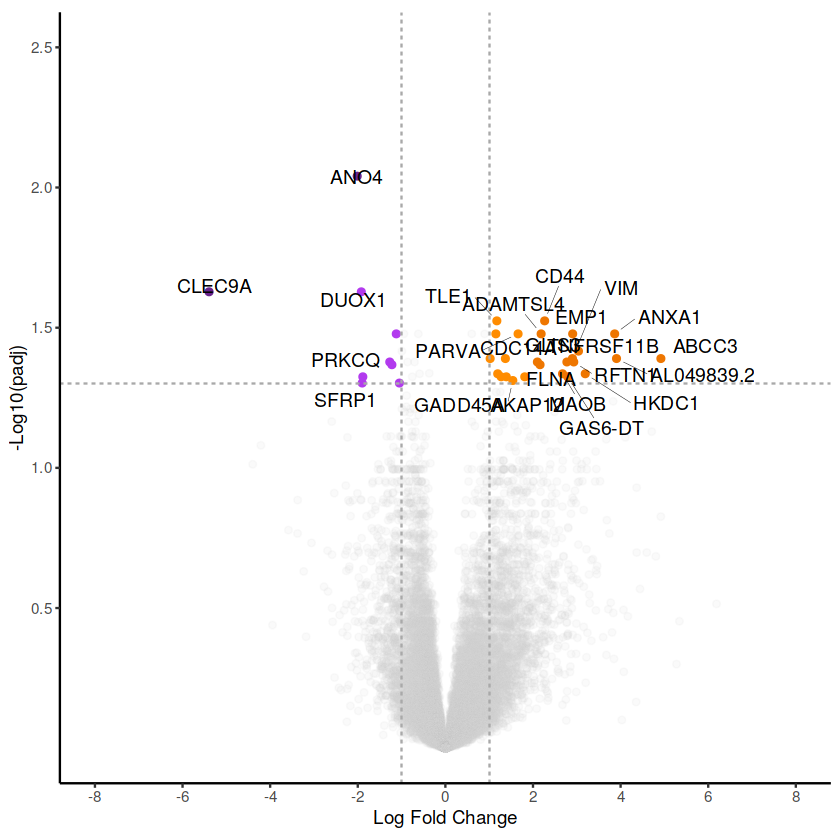

In [16]:

########################## ggplot ######################

p <- ggplot(df.volcano, aes(x=logFC, y=-log10(adj.P.Val))) +
  geom_point(aes(col=Significant, alpha = alphaVal)) +
  geom_hline(yintercept=-log10(0.05), linetype="dashed", color = "darkgrey") +
  geom_vline(xintercept = 1, linetype="dashed", color = "darkgrey") +
  geom_vline(xintercept = -1, linetype="dashed", color = "darkgrey") +
  geom_text_repel(aes(label=ifelse(name == 1 ,as.character(geneSym),'')),color="black",
                  box.padding = unit(0.3, "lines"),
                  point.padding = unit(0.5, "lines"),
                  max.overlaps = 500,
                  segment.color = 'black', size = 4, segment.size = 0.1) +
  scale_x_continuous(limits = c(-8, 8), breaks = seq(-8,8,2)) +
  scale_y_continuous(limits = c(0, 2.5), breaks = seq(0.5,3,0.5)) +
  labs(x = "Log Fold Change", y = "-Log10(padj)", color="") +
  scale_color_manual(values=c("lightgrey", "darkorange", "darkorchid2","darkorange2","darkorchid4","black","black")) + #act.inac lesion colors
  theme(aspect.ratio = 1, 
        plot.title = element_text(hjust = 0.5), 
        axis.line = element_line(colour = "black"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        panel.background = element_blank(), 
        legend.position="none")

pdf(paste0(outdir,"Volcano PL-inactive-active vs NAWM.pdf"), width = 5, height = 5) #Volcano pdf
p
dev.off()
p